In [15]:
from fastmcp import Client

from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery

from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Union
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

In [3]:
client = Client("http://localhost:8001/mcp")

async with client:
    tools = await client.list_tools()

In [4]:
tools

[Tool(name='get_formatted_context', title=None, description='Get the top k context, each representing an job posting for a given query.\n\nArgs:\n    query: The query to get the top k context for\n    top_k: The number of context chunks to retrieve, works best with 5 or more\n\nReturns:\n    A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.', inputSchema={'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}, outputSchema={'additionalProperties': True, 'type': 'object'}, annotations=None, meta={'_fastmcp': {'tags': []}})]

In [5]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_formatted_context
Get the top k context, each representing an job posting for a given query.

Args:
    query: The query to get the top k context for
    top_k: The number of context chunks to retrieve, works best with 5 or more

Returns:
    A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.
{'properties': {'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 5, 'title': 'Top K', 'type': 'integer'}}, 'required': ['query'], 'type': 'object'}


In [9]:
client = Client("http://localhost:8002/mcp")

async with client:
    # List available resources
    tools = await client.list_tools()

In [10]:
print(tools[0].name)
print(tools[0].description)
print(tools[0].inputSchema)

get_prediction
Classifies if a given job posting is real or fake.
Uses the top retrieved context from get_formatted_context as input
and return classification_result.

Args:
    text: Input string of the job posting from retrieved_context from get_formatted_context

Returns:
    A dictionary of the classification label and prediction probability score.
{'properties': {'text': {'title': 'Text', 'type': 'string'}}, 'required': ['text'], 'type': 'object'}


# Utils function - Extract tool definitions from all available tools in MCP serves

In [7]:
def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [8]:
async def get_tool_descriptions_from_mcp_servers(mcp_servers: list[str]) -> list[dict]:

    tool_descriptions = []

    for server in mcp_servers:

        client = Client(server)

        async with client:

            tools = await client.list_tools()

            for tool in tools:
                
                result = {
                    "name": "",
                    "description": "",
                    "parameters": {"type": "object", "properties": {}},
                    "required": [],
                    "returns": {"type": "string", "description": ""},
                    "server": server
                }

                result["name"] = tool.name
                result["required"] = tool.inputSchema.get("required", [])

                ## Get Description

                description = tool.description.split("\n\n")[0]
                result["description"] = description


                ## Get Returns

                returns = tool.description.split("Returns:")[1].strip()
                result["returns"]["description"] = returns

                ## Get parameters

                property_descriptions = parse_docstring_params(tool.description)
                properties = tool.inputSchema.get("properties", {})
                for key, value in properties.items():
                    properties[key]["description"] = property_descriptions.get(key, "")

                result["parameters"]["properties"] = properties

                tool_descriptions.append(result)

    return tool_descriptions

In [11]:
mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]

In [13]:
tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)
tool_descriptions

[{'name': 'get_formatted_context',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'string',
   'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_prediction',
  'description': 'Classifies if a given job posting is real or fake.\nUses the top retrieved context from get_formatted_context as input\nand return classification_result.',
  'parameters': {'type': 'object',
   'properties': {'text': {'title': 'Text',
     'type

# Agent integration to MCP Servers

In [14]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

In [16]:
# Pydantic Models

class ToolCall(BaseModel):
    name: str
    arguments: dict
    server: str

class RAGUsedContext(BaseModel):
    id: int
    description: str

class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)
    final_answer: bool = Field(default=False)
    retrieved_context_ids: List[RAGUsedContext]

class State(BaseModel):
    # existing fields...
    messages: Annotated[List[Any], add] = []
    answer: str = ""
    iteration: int = Field(default=0)
    final_answer: bool = Field(default=False)
    available_tools: List[Dict[str, Any]] = []
    tool_calls: Optional[List[ToolCall]] = Field(default_factory=list)
    retrieved_context_ids: Annotated[List[RAGUsedContext], add] = []

    # NEW fields for classifier integration
    retrieved_job_posting: Optional[str] = None            # stores the retrieved job posting text
    classification_result: Optional[Dict[str, Union[bool, float, str]]] = None  # store fraud classification result

Agent Node

In [37]:
# Example: you need a dict like this somewhere accessible
tool_name_to_server = {
    "get_prediction": "http://localhost:8002/mcp",
    "get_formatted_context": "http://localhost:8001/mcp",
    # add all your tools here
}

In [ ]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def agent_node(state: State) -> dict:

   prompt_template =  """You are a Fraud Analyst Assistant. The user is a Fraud Analyst and your job is to determine whether a job posting is real or fraudulent. 
        Use your knowledge of common fraud indicators, best practices for job verification, and any relevant information you can retrieve to support your answer.
        Always explain your reasoning and provide actionable advice. 

        User may provide either the full job posting text, job title, or a job ID. 

        If a job ID is provided, retrieve the corresponding job posting details using `get_formatted_context` before analysis.

You will be given a question and a list of tools you can use to answer that question.

If the user specifically requests classification on a job posting to tell if it is real or fake, 
you should first retrieve the posting using the `get_formatted_context` tool if you haven't already, 
then call the `get_prediction` to classify it.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When calling tools, always use:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Use names specifically provided in the available tools. Don't add any additional text to the names.

You should tend to use tools when additional information is needed to answer the question.

If you set final_answer to True, you should not use any tools.

If you have already retrieved a job posting and need to assess if it's fraudulent, you should use the `ml_classifier_tool`.


Instructions:
   1. Carefully analyze the provided job details and user input above.
   2. Use up-to-date information about job scams, legitimate job ad characteristics, and known fraud patterns.
   3. Provide a clear verdict: "Likely Real", "Likely Fraudulent", or "Uncertain".
   4. Explain your reasoning with specific evidence from the posting, user input, and retrieved information.
   5. List any red flags or positive signs you identified.
   6. Offer actionable advice to the user.
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for msg in messages:
      conversation.append(lc_messages_to_regular_messages(msg))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],xq
        temperature=0.5,
   )

    # Enrich tool calls with the 'server' field
   enriched_tool_calls = []
   for tc in response.tool_calls:
      server_url = tool_name_to_server.get(tc.name)
      if server_url is None:
         raise ValueError(f"No server URL configured for tool '{tc.name}'")
      enriched_tool_calls.append(
         ToolCall(name=tc.name, arguments=tc.arguments, server=server_url)
      )


   # if response.tool_calls:
   #    tool_calls = []
   #    for i, tc in enumerate(response.tool_calls):
   #       tool_calls.append({
   #             "id": f"call_{i}",
   #             "name": tc.name,
   #             "args": tc.arguments
   #       })

   #    ai_message = AIMessage(
   #       content=response.answer,
   #       tool_calls=tool_calls
   #       )
   # else:
   #    ai_message = AIMessage(
   #       content=response.answer,
   #    )
    # Prepare tool calls for AIMessage
   ai_message_tool_calls = []
   for i, tc in enumerate(enriched_tool_calls):
      ai_message_tool_calls.append({
         "id": f"call_{i}",
         "name": tc.name,
         "args": tc.arguments
      })

   if enriched_tool_calls:
      ai_message = AIMessage(
         content=response.answer,
         tool_calls=ai_message_tool_calls
      )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   print("[DEBUG] tool_calls so far:",  enriched_tool_calls)

   return {
      "messages": [ai_message],
      "tool_calls": enriched_tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "retrieved_context_ids": response.retrieved_context_ids
   }

In [39]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

Custom tool node function that supports running tools exposed via MCP Serves

In [40]:
async def mcp_tool_node(state: State) -> str:

    tool_messages = []

    for i, tc in enumerate(state.tool_calls):

        client = Client(tc.server)

        async with client:

            result = await client.call_tool(tc.name, tc.arguments)

            tool_message = ToolMessage(
                content=result,
                tool_call_id=f"call_{i}"
            )

            tool_messages.append(tool_message)

    return {
        "messages": tool_messages
    }

LangGraph implementation with MCP Support

In [44]:
workflow = StateGraph(State)

mcp_servers = ["http://localhost:8001/mcp", "http://localhost:8002/mcp"]

tool_descriptions = await get_tool_descriptions_from_mcp_servers(mcp_servers)

workflow.add_node("agent_node", agent_node)
workflow.add_node("mcp_tool_node", mcp_tool_node)

workflow.add_edge(START, "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "mcp_tool_node",
        "end": END
    }
)

workflow.add_edge("mcp_tool_node", "agent_node")

graph = workflow.compile()

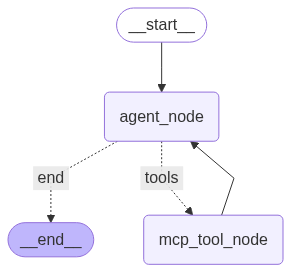

In [45]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
tool_descriptions

[{'name': 'get_formatted_context',
  'description': 'Get the top k context, each representing an job posting for a given query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'title': 'Query',
     'type': 'string',
     'description': 'The query to get the top k context for'},
    'top_k': {'default': 5,
     'title': 'Top K',
     'type': 'integer',
     'description': 'The number of context chunks to retrieve, works best with 5 or more'}}},
  'required': ['query'],
  'returns': {'type': 'string',
   'description': 'A dictionary of the top k context chunks with IDs prepending each chunk, each representing job posting for a given query.'},
  'server': 'http://localhost:8001/mcp'},
 {'name': 'get_prediction',
  'description': 'Classifies if a given job posting is real or fake.\nUses the top retrieved context from get_formatted_context as input\nand return classification_result.',
  'parameters': {'type': 'object',
   'properties': {'text': {'title': 'Text',
     'type

In [46]:
initial_state = {
    "messages": [{"role": "user", "content": "Tell me if the following job postings with job_id 10397 is real or not. Use fraud classification model on the posting if available."}],
    "available_tools": tool_descriptions
}
result = await graph.ainvoke(initial_state)

[DEBUG] tool_calls so far: [ToolCall(name='get_formatted_context', arguments={'query': 'job_id 10397', 'top_k': 1}, server='http://localhost:8001/mcp')]
[DEBUG] tool_calls so far: [ToolCall(name='get_prediction', arguments={'text': "Director of Software Engineering Company: #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model. Our focus is to help develop and achieve your career goals while makeing Job Id: 10397 Description: As Director of Software Engineering's newly forming New York development team, you will be a “player-coach” who will contribute to and drive high-level architecture and planning, manage day-to-day issues, as well as roll up your sleeves and code when necessary. Responsibilities: Inspire, mentor and lead our superb 30+ person engineering team using your experience and deep understanding of both l

In [47]:
result

{'messages': [{'role': 'user',
   'content': 'Tell me if the following job postings with job_id 10397 is real or not. Use fraud classification model on the posting if available.'},
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': 'job_id 10397', 'top_k': 1}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='CallToolResult(content=[TextContent(type=\'text\', text=\'{"retrieved_context_ids":[1],"retrieved_context":["Director of Software Engineering Company: #URL_ddb080358fa5eecf5a67c649cfb4ffc343c484389f1bbaf2a1cb071e3f2b6e7e# and Aptitude Staffing Solutions have partnered up in an effort to streamline the hiring process and provide a more efficient and effective recruitng model.\\xa0 Our focus is to help develop and achieve your career goals while makeing\\\\n    Job Id: 10397\\\\n    Description: As Director of Software Engineering\\\'s newly forming New York development team, you will be a 